# MNIST Handwritten Digit Recognition in PyTorch

PyTorch training project to build and train a CNN in PyTorch to recognize handwritten digits using the MNIST dataset. This project was borrowed from https://nextjournal.com/gkoehler/pytorch-mnist. 

The conda environment used for this notebook is available in the setup.ps1 file in this project's folder.

## Preparing the Dataset

In [1]:
import torch
import torchvision

### Hyperparameters

In [2]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Data loading

In [3]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train = True, download = True,
                                transform = torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_train, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('/files/', train = True, download = True,
                                transform = torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test, shuffle=True
)

In [4]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)
print(example_targets.shape)

torch.Size([1000, 1, 28, 28])
torch.Size([1000])


### Data visualization

In [5]:
import matplotlib.pyplot as plt

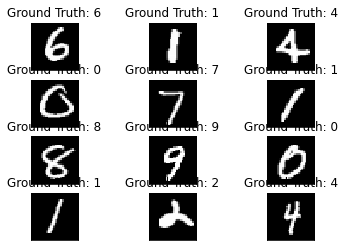

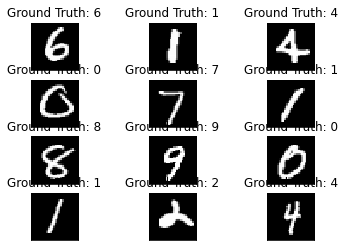

In [6]:
fig = plt.figure()
for i in range(12):
    plt.subplot(4, 3, i + 1)
    plt.tight_layout
    plt.imshow(example_data[i][0], cmap = 'gray', interpolation  = 'none')
    plt.title(f'Ground Truth: {example_targets[i]}')
    plt.xticks([])
    plt.yticks([])

## Building the Network

The network to be built is a 2-D convolutional layers followed by two fully-connected (linear) layers. The activation function will be ReLU for all units, and to regularize the network, two dropout layers we'll be added.

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

### Network class definition

In [8]:
class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size = 5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size = 5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training = self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

### Initializing the network

In [9]:
network = MNISTNet()
optimizer = optim.SGD(network.parameters(), lr = learning_rate, momentum = momentum)

## Training function

In [10]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

## Test function

In [12]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

## Running the model

In [13]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 2.2998, Accuracy: 8136/60000 (14%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294179
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.283396
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.279809
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.280572
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.273072
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.227616
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.210268
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.200505
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.090167
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.125859
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.017746
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.862992
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.819623
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.656121
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.402382
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.349152
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.437688
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.295019
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.500269
Train Epoch: 1 [12160

## Model's Performance

Text(0, 0.5, 'negative log likelihood loss')

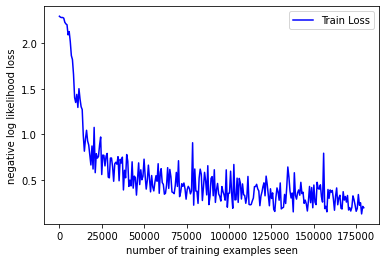

In [14]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

In [15]:
with torch.no_grad():
  output = network(example_data)

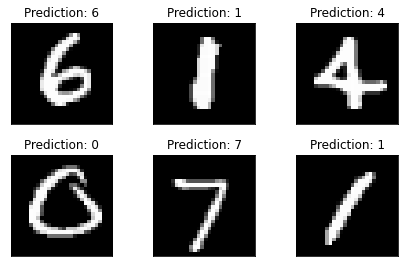

In [16]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

## Continued Training from Checkpoints

In [17]:
continued_network = MNISTNet()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [18]:
network_state_dict = torch.load('results/model.pth')
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load('results/optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [19]:
for i in range(4,9):
  test_counter.append(i * len(train_loader.dataset))
  train(i)
  test()

78%)]	Loss: 0.539951
Train Epoch: 4 [47360/60000 (79%)]	Loss: 0.175603
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.170794
Train Epoch: 4 [48640/60000 (81%)]	Loss: 0.270417
Train Epoch: 4 [49280/60000 (82%)]	Loss: 0.203264
Train Epoch: 4 [49920/60000 (83%)]	Loss: 0.273879
Train Epoch: 4 [50560/60000 (84%)]	Loss: 0.304504
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.315964
Train Epoch: 4 [51840/60000 (86%)]	Loss: 0.176760
Train Epoch: 4 [52480/60000 (87%)]	Loss: 0.472921
Train Epoch: 4 [53120/60000 (88%)]	Loss: 0.082511
Train Epoch: 4 [53760/60000 (90%)]	Loss: 0.290108
Train Epoch: 4 [54400/60000 (91%)]	Loss: 0.277554
Train Epoch: 4 [55040/60000 (92%)]	Loss: 0.207557
Train Epoch: 4 [55680/60000 (93%)]	Loss: 0.175028
Train Epoch: 4 [56320/60000 (94%)]	Loss: 0.294748
Train Epoch: 4 [56960/60000 (95%)]	Loss: 0.365278
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.259451
Train Epoch: 4 [58240/60000 (97%)]	Loss: 0.288144
Train Epoch: 4 [58880/60000 (98%)]	Loss: 0.421908
Train Epoch: 4 [59520/60000 (

Text(0, 0.5, 'negative log likelihood loss')

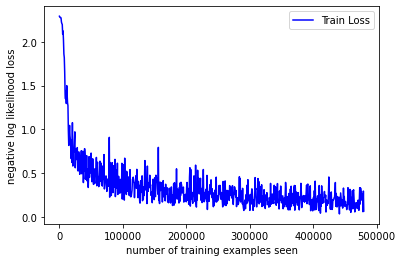

In [20]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
# plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')